### Import Libraries
#### For Embedding:
- sentence_transformers
- transformers
- torch
#### For working with data:
- pandas
- numpy
#### For Clustering:
- sklearn (KMedoins)
#### For evaluate intersection:
- adjusted rand score
#### For Visualizing:
- seaborn
- matplotlib
- PCA (to reduce dimensions to 2d)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA 
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import adjusted_rand_score
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch

### Read Dataset
- read csv with pandas
- drop columns except "score" and "content"
- Select 2000 random objects of data. Data is uniformly distributed alongside the colums "score"

In [27]:
data = pd.read_csv("netflix_reviews.csv")
data = data.drop(["reviewId","userName","thumbsUpCount","reviewCreatedVersion","at","appVersion"], axis=1)
df = data.groupby("score").sample(400).reset_index(drop=True)
df

,content,score
0,I can't watch anything on the app...... black ...,1
1,Kannada category is not available.,1
2,I sincerely hope Netflix chooses to reconsider...,1
3,App not working since update.,1
4,Bad experience. The walking dead season 10 is ...,1
...,...,...
1995,Love using on my tablet and casting it on any ...,5
1996,Good,5
1997,Netflix is really interesting and it has all t...,5
1998,I love netflix because it is only 10 dollars p...,5


### How I choose model:
- First of all I looked at the mteb (massive text embedding benchmark) leaderboard and chose two models that showed good results in clustering and were lightweight and in the community were considered good models to start with. These were ‘intfloat/e5-base-v2’ and ‘all-MiniLM-L6-v2’. However, they performed poorly. adjusted rand score was about 0.0453 and the clusters were not clearly visible when visualized. Then, after analyzing the dataset, I realized that the reviews were quite emotional and this emotionality correlated with the scores. Then, I took a model capable of recognizing emotion. It was Roberta (“cardiffnlp/twitter-roberta-base-sentiment”).
### Create embeddings   
- Create tokinazer and download model
- processes the text from df["content"] in batches
- receive embedding(vector 768 dimensions) for each batch
- save embedding in the table

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embeddings(texts):
    encoded = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded)
        embeddings = outputs.last_hidden_state.mean(dim=1) 
    return embeddings


texts = df["content"].tolist()
batch_embeddings = []

for i in range(0, len(texts), 64):
    batch = texts[i:i+64]
    batch_emb = get_embeddings(batch)
    batch_embeddings.append(batch_emb)

embeddings_tensor = torch.cat(batch_embeddings, dim=0)
embeddings = embeddings_tensor.numpy()

embeddings_data = pd.DataFrame(embeddings, columns=[f"dim_{i}" for i in range(embeddings.shape[1])])
data = pd.concat([df, embeddings_data], axis=1)
data


c:\Users\k4ty2\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,content,score,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_758,dim_759,dim_760,dim_761,dim_762,dim_763,dim_764,dim_765,dim_766,dim_767
0,I can't watch anything on the app...... black ...,1,-0.123182,-0.269154,-0.258503,-0.992610,1.254124,0.044505,0.863424,0.299069,...,0.319781,-0.014768,0.065274,-0.127127,0.162617,0.252227,0.209637,-1.095777,-0.540601,-0.798312
1,Kannada category is not available.,1,-0.185779,-0.356099,-0.050349,-0.639511,0.485261,0.802742,0.220974,0.095518,...,0.950973,0.250359,0.443816,-0.333130,-0.123670,-0.737860,-0.058152,-1.391595,-0.043356,-0.550188
2,I sincerely hope Netflix chooses to reconsider...,1,-0.373534,-0.294625,0.197669,-0.903512,1.519278,-0.577494,0.603780,-0.124425,...,0.322393,-0.105437,0.288478,-0.024780,-0.013132,0.415749,0.098911,-0.122382,-0.254897,-0.491361
3,App not working since update.,1,-0.103110,-0.170565,-0.467378,-0.802880,1.120614,0.466885,0.312649,-0.084506,...,0.272743,0.315488,0.474106,0.000817,0.688541,-0.460158,0.509910,-1.668587,-0.007504,-0.330160
4,Bad experience. The walking dead season 10 is ...,1,-0.257608,-0.393167,-0.073591,-1.151165,1.286152,-0.145809,0.788948,-0.033191,...,0.631820,-0.217257,0.527754,-0.047538,-0.090243,0.327079,0.162072,-0.790674,-0.462679,-0.857312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Love using on my tablet and casting it on any ...,5,0.331021,1.399901,-0.611240,-0.680763,0.922108,0.248347,-0.440867,-1.358815,...,-0.163880,0.286392,-0.228342,-0.220402,0.254855,1.490328,1.539657,0.662457,-0.403928,0.843823
1996,Good,5,-0.380146,1.143012,-0.165611,-0.268875,1.174733,1.267535,-0.054906,-0.725835,...,0.074782,0.171205,-0.679080,0.638286,0.400352,0.444731,1.643481,-0.382472,-0.120525,0.485685
1997,Netflix is really interesting and it has all t...,5,0.253307,1.647673,-0.418154,-0.966395,0.995138,0.613481,-0.266262,-1.014106,...,-0.347465,0.424605,-0.634429,-0.248485,0.199694,1.628432,1.671687,0.682108,-0.382158,0.961996
1998,I love netflix because it is only 10 dollars p...,5,0.492253,1.529228,-0.483752,-0.936965,1.077231,0.270879,-0.249122,-1.213055,...,-0.429496,0.243361,-0.462371,-0.380323,-0.093641,1.342426,1.569816,0.446451,-0.329871,1.188347


### Perform clusterization
- Perform clusterization with different types of distance metrics(I use Kmedoins instead Kmeans becouse it shows better results and works better with different distance)
- Find and evaluate intersection between column “content” and results of clusterization.
- Visualize results using PCA

#### Minkowski distance: 
I use Minkowski distance with p = 3, becouse Minkowski with p = 1 is manhattan distance and with p = 2 is euclidean, so I try different p and decide to stop at 3

{'euclidean': 0.17447562442925643, 'manhattan': 0.16682453650183368, 'minkowski': 0.14572901512109485}


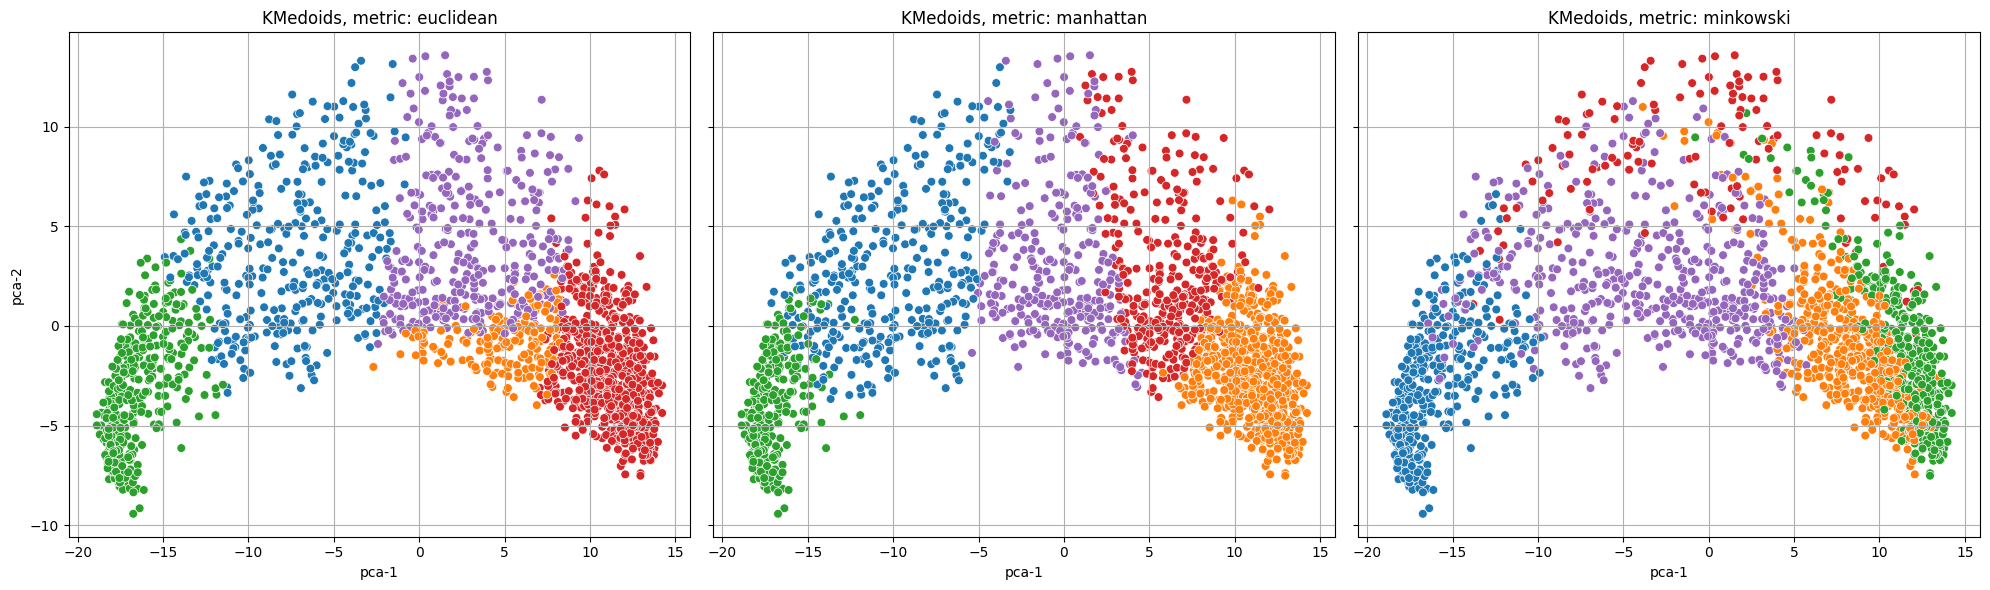

In [ ]:
def minkowski_p(x, y):
    return np.sum(np.abs(x - y) ** 3) ** (1 / 3) 

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_data)
pca_df = pd.DataFrame(pca_result, columns=["pca-1", "pca-2"])

pca_df["score"] = data["score"]

metrics = ["euclidean", "manhattan", "minkowski"]
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)

result = {}
for i, metric in enumerate(metrics):
    if metric == "minkowski":
        kmedoids = KMedoids(n_clusters=5, metric=minkowski_p, method="pam", random_state=42)
    else:
        kmedoids = KMedoids(n_clusters=5, metric=metric, random_state=42)
    clusters = kmedoids.fit(embeddings_data)
    Rand_index = adjusted_rand_score(data["score"], clusters.labels_)
    result[metric] = Rand_index
    pca_df["cluster"] = clusters.labels_
    
    sns.scatterplot(
        data=pca_df,
        x="pca-1", y="pca-2",
        hue="cluster",
        palette="tab10",
        ax=axes[i],
        s=40,
        legend=False
    )
    axes[i].set_title(f"KMedoids, metric: {metric}")
    axes[i].grid(True)

print(result)
plt.tight_layout()
plt.show()

#### Conclusion
As part of the lab work, I generated embeddings to reviews from the Netflix Reviews dataset. Then applied clustering with different distance metrics. and then find and evaluate the intersection between column “content” and results of clusterization using adjusted rand score and got an average of 0.17. Clustering with Euclidean distance showed the best performance. Then I vizualise it. 